# Imports

In [ ]:
import os, re
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import scipy.io as so
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

import sys
sys.path.append('/content/drive/MyDrive/Penn/PySleep')
import sleepy


# Fixed Parameters
nbin = 2500
sr = 1000
ppath = '/content/drive/MyDrive/Penn/RawData/Pwaves'


# Key parameters
iwin = 250


Mounted at /content/drive


# Data Preparation

In [ ]:
train_recordings, test_recordings = sleepy.load_recordings(ppath, 'pwave_files1.txt')
recordings = train_recordings + test_recordings

recording_map = {}
for rec in train_recordings:
    recording_map[rec] = 'train'
for rec in test_recordings:
    recording_map[rec] = 'test'


train_data = []
all_test_data = []

train_target = []
all_test_target = []
file_names = []

for name in recordings:
    temp_test_target = []
    temp_test_data = []
    print(name)
    # load brain states
    M = sleepy.load_stateidx(ppath, name)[0]
    # load indices of p-waves
    pwave_dict = so.loadmat(os.path.join(ppath, name, 'p_idx.mat'), squeeze_me=True)
    # channel used for p-wave detection
    lfp_channel = pwave_dict['channel']
    # indices of p-waves
    pidx = pwave_dict['p_idx']

    lfp_name = 'LFP_raw'
    if lfp_channel == '1':
        lfp_name = lfp_name
    else:
        lfp_name = lfp_name + str(lfp_channel)
    # load LFP data:
    try:
        LFP = so.loadmat(os.path.join(ppath, name, lfp_name + '.mat'), squeeze_me=True)[lfp_name]
    except:
        lfp_name = 'LFP'
        LFP = so.loadmat(os.path.join(ppath, name, lfp_name + '.mat'), squeeze_me=True)[lfp_name]

    print('Used LFP channel: %s' % lfp_name)

    # Go through each REM episode, cut out consecutive windows of size 2*iwin and then check whether the window contains a p-wave or not
    # get all REM sleep sequences
    if recording_map[name] == 'train':
        seq = sleepy.get_sequences(np.where(M==1)[0])
    else:
        seq = sleepy.get_sequences(np.where(M!=11)[0])

    # go through each REM sleep episode:
    #for s in seq:
    pidx_rem = []

    for s in seq:
        si = s[0]*nbin
        sj = s[-1]*nbin+1

        for a in np.arange(si, sj, iwin):
            # a is the start of an LFP window:
            window = LFP[a:a+iwin]

            if recording_map[name] == 'train':
                train_data.append(window)
            else:
                temp_test_data.append(window)

            # test if @window contains a P-wave
            hits = np.where((pidx >= a) & (pidx < a+iwin))[0]

            label = 0
            if len(hits) > 0:
                label = 1

            if recording_map[name] == 'train':
                train_target.append(label)
            else:
                temp_test_target.append(label)
    if recording_map[name] == 'test':
        file_names.append(name)
        temp_test_data = np.array(temp_test_data)
        temp_test_target = np.array(temp_test_target)
        all_test_data.append(temp_test_data)
        all_test_target.append(temp_test_target)


train_data = np.array(train_data)

train_target = np.array(train_target)


EP031_032923n1
Used LFP channel: LFP_raw2
EP88_101023n1
Used LFP channel: LFP
EP90_101023n1
Used LFP channel: LFP
EP90_101123n1
Used LFP channel: LFP_raw2
EP90_101223n1
Used LFP channel: LFP_raw
EP109_012524n1
Used LFP channel: LFP_raw
EP112_121423n1
Used LFP channel: LFP_raw
EP112_121523n1
Used LFP channel: LFP_raw
EP113_121423n1
Used LFP channel: LFP_raw2
EP113_121523n1
Used LFP channel: LFP_raw2
EP114_121423n1
Used LFP channel: LFP_raw
EP114_121523n1
Used LFP channel: LFP_raw
EP115_010324n1
Used LFP channel: LFP_raw2
EP132_022124n1
Used LFP channel: LFP_raw
EP159_051024n1
Used LFP channel: LFP_raw2
EP116_122023n1
Used LFP channel: LFP_raw
EP118_122023n1
Used LFP channel: LFP_raw
EP117_122023n1
Used LFP channel: LFP_raw2
EP030_032923n1
Used LFP channel: LFP_raw


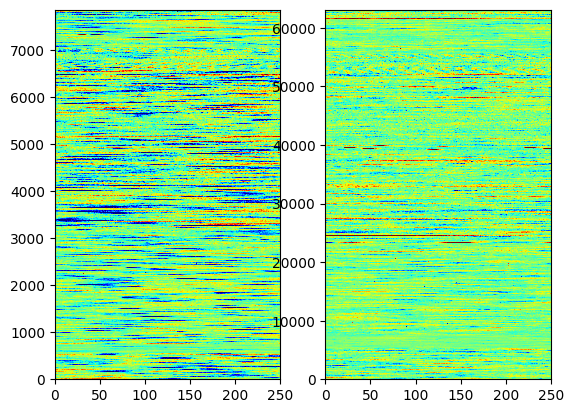

In [ ]:
# balance training data set:
# show windows with p-wave:
hit_idx = np.where(train_target == 1)[0]
non_idx = np.setdiff1d(np.arange(0, train_data.shape[0]), hit_idx)
fix, axs = plt.subplots(1,2)
axs[0].pcolormesh(train_data[hit_idx,:], cmap='jet', vmin=-200,vmax=200)
axs[1].pcolormesh(train_data[non_idx,:], cmap='jet', vmin=-200,vmax=200)

num_hit = len(hit_idx)

# select randomly $num_hit samples from non_idx
idx = np.random.choice(len(non_idx), num_hit)
sel_nonidx = non_idx[idx]

pos_data = train_data[hit_idx,:]
pos_target = train_target[hit_idx]

neg_data   = train_data[sel_nonidx,:]
neg_target = train_target[sel_nonidx]

all_data = np.concatenate((pos_data, neg_data))
all_target = np.concatenate((pos_target, neg_target))

# shuffle train_data
n = len(all_target)
ii = np.random.choice(n, n)
all_data   = all_data[ii,:]
all_target = all_target[ii]


# CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(all_data, dtype=torch.float32)
 # the dimensionality of the input is batch_size, num_channels, signal_length;
X_train_tensor = X_train_tensor.unsqueeze(1)
y_train_tensor = torch.tensor(all_target, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# setup up independent test data set
# Convert to PyTorch tensors

test_loaders = []
for i in range(len(all_test_data)):
    test_data = all_test_data[i]
    test_target = all_test_target[i]
    X_test_tensor = torch.tensor(test_data, dtype=torch.float32)
    X_test_tensor = X_test_tensor.unsqueeze(1)
    y_test_tensor = torch.tensor(test_target, dtype=torch.float32).view(-1, 1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    test_loaders.append(test_loader)


In [ ]:
# Define the CNN model
class PWaveDetectorCNN(nn.Module):
    def __init__(self, kernel_size=5, input_size=60, num_channels=1):
        super(PWaveDetectorCNN, self).__init__()
        # the dimensionality of the input is batch_size, num_channels, signal_length;
        # since we're processing only one signal (the LFP channel) num_channels is 1

        dropout_prob_conv = 0.3
        dropout_prob_fc = 0.5

        kernel_size = 3
        num_filters = 32
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=kernel_size)
     #   self.bn1 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(dropout_prob_conv)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size)
    #    self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(dropout_prob_conv)

       # self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
      # self.bn3 = nn.BatchNorm1d(128)
      #  self.pool3 = nn.MaxPool1d(kernel_size=2)
      #  self.dropout3 = nn.Dropout(dropout_prob_conv)
      #  self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3)
        self.flatten = nn.Flatten()


        # Calculate the size of the feature map after the conv and pool layers
        n = input_size
        n = (n - kernel_size + 1) // 2  # After conv1 and pool1
        n = (n - kernel_size + 1) // 2  # After conv2 and pool2
     #   n = (n - 3 + 1) // 2  # After conv3 and pool3
  #      n = (n - 3 + 1) // 2  # After conv4 and pool4

        self.fc1 = nn.Linear(64 * int(n), 64)  # 128 filters, each reduced to length 22 after conv and pooling
        self.dropout_fc1 = nn.Dropout(dropout_prob_fc) #dropout probability of 0.5
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout2(x)
     #   x = self.pool(torch.relu(self.conv3(x)))
     #   x = self.dropout3(x)
     #   x = self.pool(torch.relu(self.conv4(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        self.dropout_fc1(x)
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model, define the loss function and the optimizer
model = PWaveDetectorCNN(input_size=iwin, kernel_size=9)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
num_epochs = 100
patience = 15
best_val_loss = float('inf')
early_stop_counter = 0
train_array = []
val_array = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_array.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
           # print(outputs)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_array.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        file_path = os.path.join(ppath, 'cnn_pwave.pth')
        torch.save(model.state_dict(), file_path)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping")
            break


Epoch 1/100, Train Loss: 0.5750, Val Loss: 0.3812
Epoch 2/100, Train Loss: 0.4494, Val Loss: 0.3741
Epoch 3/100, Train Loss: 0.4140, Val Loss: 0.3536
Epoch 4/100, Train Loss: 0.3681, Val Loss: 0.3408
Epoch 5/100, Train Loss: 0.3444, Val Loss: 0.3292
Epoch 6/100, Train Loss: 0.3304, Val Loss: 0.3338
Epoch 7/100, Train Loss: 0.3134, Val Loss: 0.3028
Epoch 8/100, Train Loss: 0.2958, Val Loss: 0.3009
Epoch 9/100, Train Loss: 0.2863, Val Loss: 0.3061
Epoch 10/100, Train Loss: 0.2738, Val Loss: 0.3188
Epoch 11/100, Train Loss: 0.2641, Val Loss: 0.2942
Epoch 12/100, Train Loss: 0.2556, Val Loss: 0.2627
Epoch 13/100, Train Loss: 0.2451, Val Loss: 0.2578
Epoch 14/100, Train Loss: 0.2329, Val Loss: 0.2652
Epoch 15/100, Train Loss: 0.2193, Val Loss: 0.2488
Epoch 16/100, Train Loss: 0.2194, Val Loss: 0.2697
Epoch 17/100, Train Loss: 0.2080, Val Loss: 0.2348
Epoch 18/100, Train Loss: 0.1963, Val Loss: 0.2464
Epoch 19/100, Train Loss: 0.1951, Val Loss: 0.2462
Epoch 20/100, Train Loss: 0.1842, Val Lo

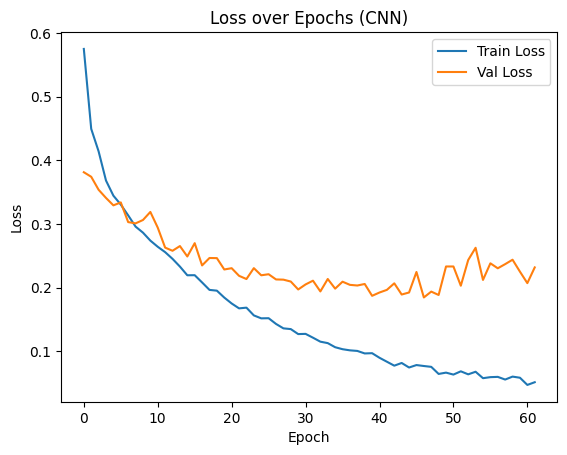

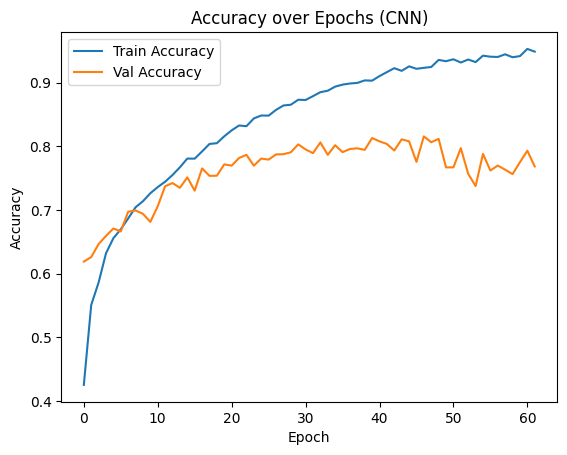

In [ ]:
fig1 = plt.figure("Loss over Epochs")
plt.title("Loss over Epochs (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_array, label = "Train Loss")
plt.plot(val_array, label = "Val Loss")
plt.legend()

train_accuracy = [1 - x for x in train_array]
val_accuracy = [1 - x for x in val_array]

fig2 = plt.figure("Accuracy over Epochs")
plt.title("Accuracy over Epochs (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, label = "Train Accuracy")
plt.plot(val_accuracy, label = "Val Accuracy")
plt.legend()

In [ ]:
# Load the best model
file_path = os.path.join(ppath, 'cnn_pwave.pth')
model.load_state_dict(torch.load(file_path))


model.eval()
all_predictions = []

for i in range(len(test_loaders)):
    test_loader = test_loaders[i]
    name = file_names[i]
    test_loss = 0.0
    predictions = []
    true_labels = []
    test_array = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_array.append(loss.item())
            test_loss += loss.item() * X_batch.size(0)

            binary_predictions = (outputs.squeeze() > 0.5).float()
            if binary_predictions.dim() == 0:
                predictions.append(binary_predictions.item())
            else:
                predictions.extend(binary_predictions.tolist())

            y = [y[0].item() for y in y_batch]
            true_labels.extend(y)

    test_loss /= len(test_loader.dataset)
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    all_predictions.append(predictions)
    print(name + ':')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Average Prediction Accuracy: {np.sum(predictions == true_labels) / len(predictions):.4f}')
    print()


EP030_032923n1:
Test Loss: 0.1691
Average Prediction Accuracy: 0.9548



In [ ]:
all_pidx_gen = []
for i in range(len(test_loaders)):
    #generates pidx within test_data
    predictions = all_predictions[i]
    test_data = all_test_data[i]
    name = file_names[i]

    pidx_gen = []

    for i in range(len(predictions)):
        if predictions[i] == 1:
          test_window = test_data[i]
          num = iwin * i
          minpos = np.argmin(test_window)
          pidx_gen.append(num + minpos)

    pidx_gen = np.array(pidx_gen)
    all_pidx_gen.append(pidx_gen)

    #write to file
    pwave_dict['p_idx'] = pidx_gen
    so.savemat(os.path.join(ppath, name, 'p_idx_cnn.mat'), pwave_dict)
    print(name)

EP030_032923n1


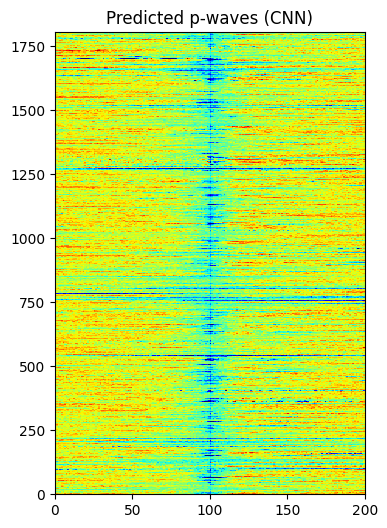

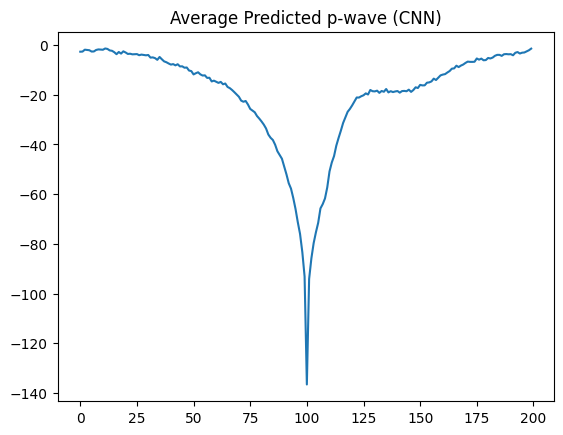

In [ ]:
for i in range(len(test_loaders)):
    pidx_gen = all_pidx_gen[i]
    name = file_names[i]
    lfp_name = 'LFP_raw'
    try:
        LFP = so.loadmat(os.path.join(ppath, name, lfp_name + '.mat'), squeeze_me=True)[lfp_name]
    except:
        lfp_name = 'LFP'
        LFP = so.loadmat(os.path.join(ppath, name, lfp_name + '.mat'), squeeze_me=True)[lfp_name]

    # get all P-waves:
    iwin2 = 100

    data = []
    peaks = []
    for i in pidx_gen:
        peaks.append(LFP[i])
        if i >= iwin2 and i+iwin2 < LFP.shape[0]:
            tmp = LFP[i-iwin2:i+iwin2]
            data.append(tmp)

    pwaves = np.array(data)

    # Show p-waves as heatmap and average in line plot
    #plt.imshow(pwaves, cmap='jet')
    plt.figure(figsize=(4,6))
    plt.pcolormesh(pwaves, cmap='jet', vmin = -250, vmax = 150)
    plt.title("Predicted p-waves (CNN)")
    plt.figure()
    plt.title("Average Predicted p-wave (CNN)")
    plt.plot(pwaves[:,:].mean(axis=0))

# LSTM Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(all_data, dtype=torch.float32)
 # the dimensionality of the input is batch_size, num_channels, signal_length;
X_train_tensor = X_train_tensor.unsqueeze(-1)
y_train_tensor = torch.tensor(all_target, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset1 = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset1, batch_size=32, shuffle=False)

test_loaders = []
for i in range(len(all_test_data)):
    test_data = all_test_data[i]
    test_target = all_test_target[i]
    X_test_tensor = torch.tensor(test_data, dtype=torch.float32)
    X_test_tensor = X_test_tensor.unsqueeze(-1)
    y_test_tensor = torch.tensor(test_target, dtype=torch.float32).view(-1, 1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    test_loaders.append(test_loader)

In [ ]:
import torch
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(BiLSTMModel, self).__init__()

        # Define the LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)

        # Define a fully connected (dense) layer
        self.fc = nn.Linear(hidden_size * 2, 1)  # hidden_size * 2 because of bidirectionality

        # Sigmoid layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through LSTM layers
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, seq_len, hidden_size * 2)

        # Use the output from the last time step for the fully connected layer
        last_time_step_output = lstm_out[:, -1, :]

        # Pass the last time step output through the fully connected layer
        fc_output = self.fc(last_time_step_output)

        # Apply the sigmoid activation to get probabilities
        output = self.sigmoid(fc_output)

        return output


# Define model parameters
input_size = 1    # Number of features in the input
hidden_size = 50   # Number of hidden units in the LSTM
output_size = 1    # Number of classes or output size
num_layers = 2     # Number of LSTM layers
dropout = 0.3      # Dropout rate

# Instantiate the model, define the loss function and the optimizer
model = BiLSTMModel(input_size, hidden_size, output_size, dropout)
device = torch.device('cpu')
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
num_epochs = 100
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0
train_array = []
val_array = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_array.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
           # print(outputs)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_array.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        file_path = os.path.join(ppath, 'lstm_pwave.pth')
        torch.save(model.state_dict(), file_path)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping")
            break


Epoch 1/100, Train Loss: 0.6548, Val Loss: 0.6280
Epoch 2/100, Train Loss: 0.5577, Val Loss: 0.4864
Epoch 3/100, Train Loss: 0.4665, Val Loss: 0.4399
Epoch 4/100, Train Loss: 0.4689, Val Loss: 0.4624
Epoch 5/100, Train Loss: 0.4328, Val Loss: 0.4081
Epoch 6/100, Train Loss: 0.4137, Val Loss: 0.4344
Epoch 7/100, Train Loss: 0.4339, Val Loss: 0.4323
Epoch 8/100, Train Loss: 0.4208, Val Loss: 0.4270
Epoch 9/100, Train Loss: 0.3959, Val Loss: 0.4025
Epoch 10/100, Train Loss: 0.3858, Val Loss: 0.4244
Epoch 11/100, Train Loss: 0.3821, Val Loss: 0.3670
Epoch 12/100, Train Loss: 0.4590, Val Loss: 0.4245
Epoch 13/100, Train Loss: 0.4773, Val Loss: 0.5538
Epoch 14/100, Train Loss: 0.4159, Val Loss: 0.4114
Epoch 15/100, Train Loss: 0.3744, Val Loss: 0.3947
Epoch 16/100, Train Loss: 0.3819, Val Loss: 0.4157
Early stopping


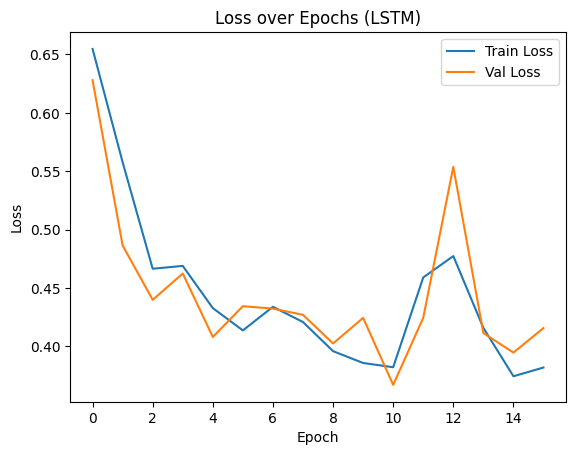

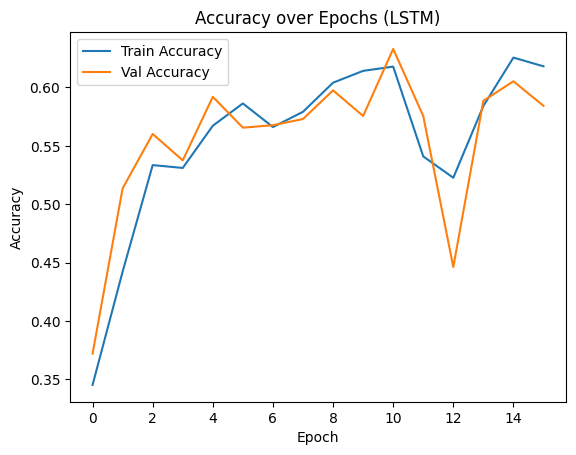

In [ ]:
fig1 = plt.figure("Loss over Epochs")
plt.title("Loss over Epochs (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_array, label = "Train Loss")
plt.plot(val_array, label = "Val Loss")
plt.legend()

train_accuracy = [1 - x for x in train_array]
val_accuracy = [1 - x for x in val_array]

fig2 = plt.figure("Accuracy over Epochs")
plt.title("Accuracy over Epochs (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_accuracy, label = "Train Accuracy")
plt.plot(val_accuracy, label = "Val Accuracy")
plt.legend()


In [ ]:
# Load the best model
file_path = os.path.join(ppath, 'lstm_pwave.pth')
model.load_state_dict(torch.load(file_path))

model.eval()

for i in range(len(test_loaders)):
    test_loader = test_loaders[i]
    name = file_names[i]
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)

            binary_predictions = (outputs.squeeze() > 0.5).float()
            if binary_predictions.dim() == 0:
                predictions.append(binary_predictions.item())
            else:
                predictions.extend(binary_predictions.tolist())

            y = [y[0].item() for y in y_batch]
            true_labels.extend(y)

    test_loss /= len(test_loader.dataset)
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    print(name + ':')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Average Prediction Accuracy: {np.sum(predictions == true_labels) / len(predictions):.4f}')

EP030_032923n1:
Test Loss: 0.2180
Average Prediction Accuracy: 0.9355


In [ ]:
all_pidx_gen = []
for i in range(len(test_loaders)):
    #generates pidx within test_data
    predictions = all_predictions[i]
    test_data = all_test_data[i]
    name = file_names[i]

    pidx_gen = []

    for i in range(len(predictions)):
        if predictions[i] == 1:
          test_window = test_data[i]
          num = iwin * i
          minpos = np.argmin(test_window)
          pidx_gen.append(num + minpos)

    pidx_gen = np.array(pidx_gen)
    all_pidx_gen.append(pidx_gen)

    #write to file
    pwave_dict['p_idx'] = pidx_gen
    so.savemat(os.path.join(ppath, name, 'p_idx_lstm.mat'), pwave_dict)
    print(name)

EP030_032923n1


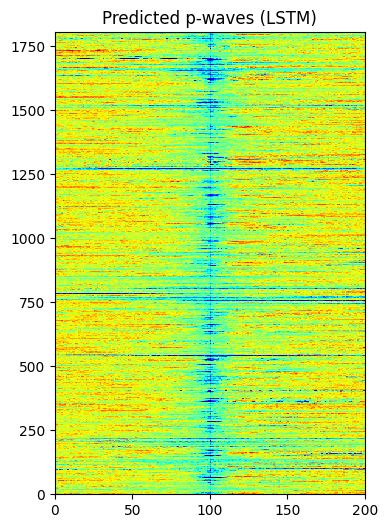

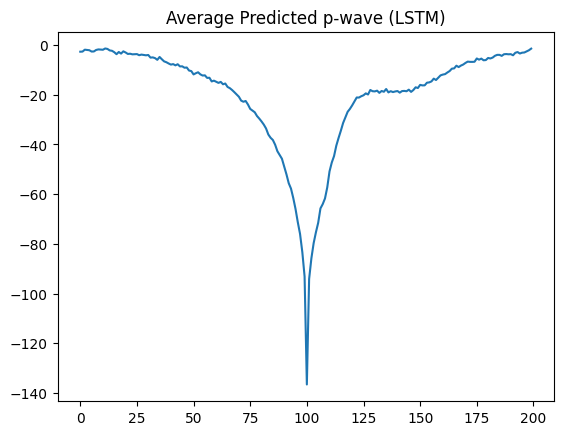

In [ ]:
for i in range(len(test_loaders)):
    name = file_names[i]
    lfp_name = 'LFP_raw'
    try:
        LFP = so.loadmat(os.path.join(ppath, name, lfp_name + '.mat'), squeeze_me=True)[lfp_name]
    except:
        lfp_name = 'LFP'
        LFP = so.loadmat(os.path.join(ppath, name, lfp_name + '.mat'), squeeze_me=True)[lfp_name]

    # get all P-waves:
    iwin2 = 100

    data = []
    peaks = []
    for i in pidx_gen:
        peaks.append(LFP[i])
        if i >= iwin2 and i+iwin2 < LFP.shape[0]:
            tmp = LFP[i-iwin2:i+iwin2]
            data.append(tmp)

    pwaves = np.array(data)

    # Show p-waves as heatmap and average in line plot
    #plt.imshow(pwaves, cmap='jet')
    plt.figure(figsize=(4,6))
    plt.pcolormesh(pwaves, cmap='jet', vmin = -250, vmax = 150)
    plt.title("Predicted p-waves (LSTM)")
    plt.figure()
    plt.title("Average Predicted p-wave (LSTM)")
    plt.plot(pwaves[:,:].mean(axis=0))

Text(0.5, 1.0, 'Actual p-waves (All)')

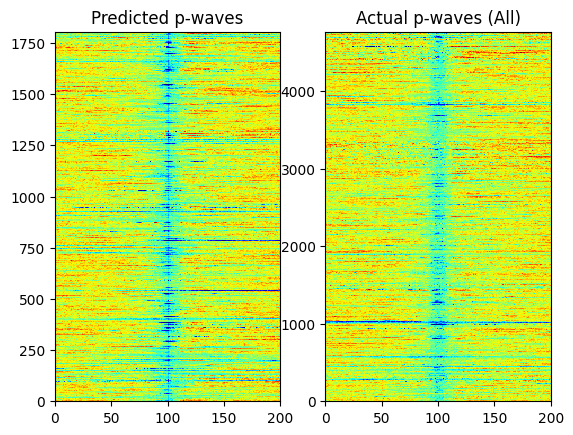

In [ ]:
# get all P-waves:

data2 = []
peaks2 = []
for i in pidx:
    peaks2.append(LFP[i])
    if i >= iwin2 and i+iwin2 < LFP.shape[0]:
        tmp = LFP[i-iwin2:i+iwin2]
        data2.append(tmp)

pwaves_og = np.array(data2)


fix, axs = plt.subplots(1,2)
axs[0].pcolormesh(pwaves, cmap='jet', vmin = -250, vmax = 150)
axs[0].set_title("Predicted p-waves")
axs[1].pcolormesh(pwaves_og, cmap='jet', vmin = -250,vmax = 150)
axs[1].set_title("Actual p-waves (All)")